# Other random distributions on quantum computers

In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer
from qiskit.visualization import plot_histogram
backend = BasicAer.get_backend('qasm_simulator')

The previous notebook showed how a quantum computer could be programmed to generate a uniform random distribution from two qubits. It was a pretty trivial algorithm, and compared with the complexity of generating pseudo-random numbers on a digital computer, showed the advantage of using quantum computers for this application. However, given that quantum computing is largely about manipulating probabilities, it's natural to consider how other, non-uniform, random number distributions might be calculated using a quantum computer.

Of course, you could just take the uniformly distributed random bits from the quantum computer and make it fit a different distribution on a digital computer, but let's see how far we can get using just a quantum computer.

### Bell state
A special type of quantum state is known as the [Bell state](https://en.wikipedia.org/wiki/Bell_state). There are actually four Bell states, but for simplicity, we'll just pick one. To put a two qubit quantum computer into a Bell state, we will manipulate it to have the state vector $\begin{bmatrix}
    \frac{1}{\sqrt{2}} \\
    0.0 \\
    0.0 \\
    \frac{1}{\sqrt{2}} \\
\end{bmatrix}$ which means that a measurement will get either the $|00\rangle$ or $|11\rangle$ outcomes with equal probability, but the $|01\rangle$ and $|10\rangle$ outcomes won't appear at all. Another way to think of this is flipping two coins, and having them always end up heads-heads or tails-tails, but never getting a heads-tails result.

To get this state vector, it's not enough to use the H operation, but we need something called the CX operation.

### CX operation
The CX operation can be thought of as a "constrained swap" operation which affects pairs of rows in the state vector specified by the states of two qubits (rather than specified by just one qubit, like we saw with the H operation). The pairs of rows that will be swapped are constrained to those where the first qubit in the $|1\rangle$ state and that otherwise only differ by the value of the second qubit.

For example, if we start with the usual initial state vector for two qubits:
| Qubits| Initial state vector |  
| -: | -: | 
| $|00\rangle$ | $1.0$ |
| $|01\rangle$ | $0.0$ | 
| $|10\rangle$ | $0.0$ | 
| $|11\rangle$ | $0.0$ | 

where the $|00\rangle$ outcome has a 100% probability, and now apply the CX operation against the right-most qubit then the left-most qubit, or CX(0,1) to use the Qiskit numbering for qubits, the state vector wouldn't change at all, since the pair of rows where the right-most qubit is $|1\rangle$ are both the same, i.e. 0.0, so swapping doesn't change anything.

However, if we firstly, use the H operator on rows associated with the right-most qubit, or an H(0) operation, and then perform the same CX(0,1) operation, we get a more interesting result:
| Qubits| Initial state vector | Calculating H(0) | Result H(0) | Calculating CX(0,1) | Result of CX(0,1) |
| -: | -: | -: | -: | -: | -: |
| $|00\rangle$ | $1.0$ | $= \frac{1.0 + 0.0}{\sqrt{2}}$ | $\frac{1}{\sqrt{2}}$ | unchanged | $\frac{1}{\sqrt{2}}$ |
| $|01\rangle$ | $0.0$ | $= \frac{1.0 - 0.0}{\sqrt{2}}$ | $\frac{1}{\sqrt{2}}$ | $= 0.0$ | $0.0$ |
| $|10\rangle$ | $0.0$ | $= \frac{0.0 + 0.0}{\sqrt{2}}$ | $0.0$ | unchanged | $0.0$ |
| $|11\rangle$ | $0.0$ | $= \frac{0.0 - 0.0}{\sqrt{2}}$ | $0.0$ | $= \frac{1}{\sqrt{2}}$ | $\frac{1}{\sqrt{2}}$ |

Swapping the rows made a change this time, and we have ended up with the Bell state that we were talking about above.

### Implementing this on Qiskit
Now, let's create a histogram of the results we get from performing this on a (simulated) quantum computer, and check that it does what we expect. We'll use the same approach on Qiskit as we did last time.

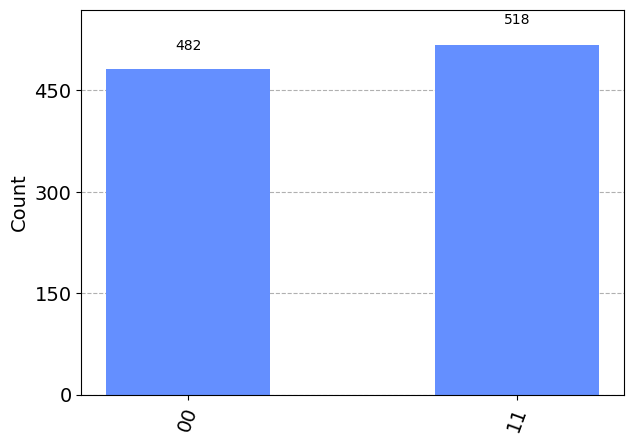

In [2]:
q = QuantumRegister(2)         # We want 2 qubits
c = ClassicalRegister(2)       # and also 2 bits
circuit = QuantumCircuit(q, c) # Set up the quantum computer, a.k.a. quantum circuit
circuit.h(0)                   # Apply H operation on pairs of rows related to qubit 0
circuit.cx(0,1)                # Apply CX operation, constrained to rows where qubit 0 is |1>, swapping qubit 1's rows
circuit.measure(q, c)          # Measure the qubits and get some bits

result = execute(circuit, backend, shots=1000).result()    # Run this all 1,000 times
plot_histogram(result.get_counts(circuit))                 # Show a histogram of the results

Yes, this the random distribution we were hoping to get. It is just `00` and `11` with no `01` or `10` results.

### RY operation
We've achieved a non-uniform distribution, but it's not a very interesting one. Each outcome is still equally likely. We will need another operation to help with that, and I'm now going to introduce the RY operation.

RY adjusts the pairs of state vector rows applying to a specified qubit, and adjusts them by a specified "angle". If the angle is pi ($\pi$), which is an amount in radians equivalent to 180 degrees, the adjustment results in a swap of values and flipping the sign of the first value (we'll come back to this). But the swap is modified relative to the angle, so we can think of it like a "relative swap" operation.

Let's have a look at at how it would work on the standard initial state vector, with the specific qubit being the right-most one (or, qubit 0), and for some different angles:
| Qubits| Initial state vector | RY(0.0,0) | RY($\pi$,0) | RY($\pi$,0) again | RY($\frac{\pi}{2}$,0) |
| -: | -: | -: | -: | -: | -: |
| $|00\rangle$ | $1.0$ | $1.0$ | $0.0$ | $-1.0$ | $-\frac{1}{\sqrt{2}}$ |
| $|01\rangle$ | $0.0$ | $0.0$ | $1.0$ | $0.0$ | $-\frac{1}{\sqrt{2}}$ |
| $|10\rangle$ | $0.0$ | $0.0$ | $0.0$ | $0.0$ | $0.0$ |
| $|11\rangle$ | $0.0$ | $0.0$ | $0.0$ | $0.0$ | $0.0$ |

The first time the RY operation is used, it is given a specified angle of 0.0, and it does absolutely nothing to the state vector. This is correct - with an angle of 0.0, RY will not change anything.

Next, we can see that when the RY($\pi$,0) operation happens, it swaps the values where the right-most qubit (qubit 0) differ, i.e. the first and second row, and the third and fourth row. In addition, it flips the sign on the first of each pair of rows. The first time RY happens, it simply moves the 100% outcome from $|00\rangle$ to $|01\rangle$. The second time RY happens, it moves this outcome back to $|00\rangle$ and flips the sign to negative.

What does -100% mean? How can this be a probability? Well, each row of the state vector is a *probability amplitude* rather than a probability. If a probability amplitude is a real number, i.e. no imaginary component, you can turn it into its corresponding probability by just squaring it. -1.0 $\times$ -1.0 is 1.0, so -100% as a probability amplitude is equivalent to a 100% probability. Note that this isn't just some oddity, but actually part of what makes quantum computers powerful.

The final application of the RY operation in the table is with a specified angle that is $\frac{\pi}{2}$ which corresponds to 90 degrees. It's mid-way between 0.0 and $\pi$, and produces a result that is also mid-way between the previous results. Where the 0.0 angle didn't move any of the probability amplitude values between the pairs, and the $\pi$ angle moved all of the probability amplitude values to the alternate row in each pair, the $\frac{\pi}{2}$ angle is halfway between those angles and it moved half the probability amplitude, in the same way the H operator did in the previous notebook.

In fact, we can pick an angle to give to the RY operation that will move a desired fraction of the probability amplitude value between the rows. To swap a fraction $f$ of the value from the first row to the second, and bring the opposite fraction (i.e. $1 - f$) from the second row but with the sign flipped, you use the angle calculated by $2 \times arcsin(\sqrt{f})$. For our final application of RY above, it had the fraction $f = \frac{1}{2}$, and it turns out $2 \times arcsin(\sqrt{\frac{1}{2}}) = \frac{\pi}{2}$ which is the angle used in the operation.

We can now use this knowledge to create a range of specific probability distributions for our random bits. The set of operations we have talked about so far - H, CX and RY - should allow us to create any probability distribution. For example, if we want to create a probability distribution where it is equally likely that any of the first three outcomes ($|00\rangle$, $|01\rangle$, and $|10\rangle$) happen and yet the last outcome ($|11\rangle$) shouldn't happen, the state vector we'd want to create is:
$\begin{bmatrix}
    \frac{1}{\sqrt{3}} \\
    \frac{1}{\sqrt{3}} \\
    \frac{1}{\sqrt{3}} \\
    0.0 \\
\end{bmatrix}$.

A way to get this is to recognise that (if we look at the rows relating to qubit 1), the first pair of outcomes are twice as likely as the second pair of outcomes. We can use the RY operation to swap (the square root) of a third of the overall probability to the second pair. We can then use a sequence of RY, CX and RY operations to spread the probabilities within each pair. This looks like:
| Qubits| Initial state vector | <nobr>RY(2 $\times$ arcsin($\sqrt{1/3}$),1)</nobr> | RY($\frac{3\pi}{4}$,0) | CX(1,0) | <nobr>RY($-\frac{\pi}{4}$,0)</nobr> |
| :- | :- | :- | :- | :- | :- |
| $|00\rangle$ | $1.0$ | $\sqrt{\frac{2}{3}}$ | $0.3125$ | $0.3125$ | $\sqrt{\frac{1}{3}}$ |
| $|01\rangle$ | $0.0$ | $0.0$                | $0.7543$ | $0.7543$ | $\sqrt{\frac{1}{3}}$ |
| $|10\rangle$ | $0.0$ | $\sqrt{\frac{1}{3}}$ | $0.2209$ | $0.5334$ | $\sqrt{\frac{1}{3}}$ |
| $|11\rangle$ | $0.0$ | $0.0$                | $0.5334$ | $0.2209$ | $0.0$                |

Exactly why this works would require getting quite deep into what is called "amplitude embedding" or "state preparation", and there are various algorithms to do this. The above procedure was inspired by [a paper by Mottonen,
Vartiainen, Bergholm, and Salomaa](https://arxiv.org/pdf/quant-ph/0407010.pdf). The main thing to note is that quantum computers allow arbitrary non-uniform distributions to be constructed.

### Implementing this on Qiskit
Let's test the above procedure and see if it does what we expect.

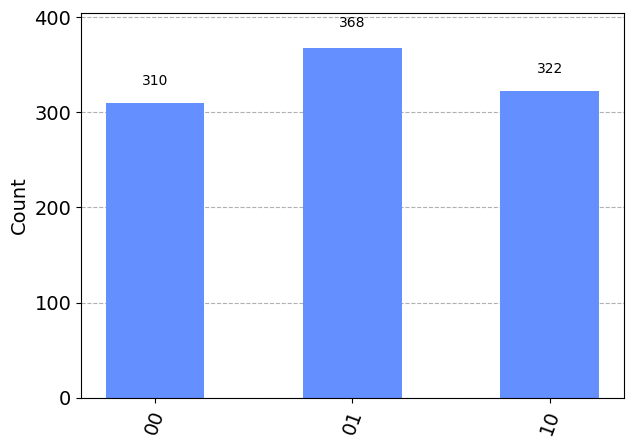

In [3]:
angle1 = 2 * np.arcsin(np.sqrt(1.0/3.0))
angle2 = 3/4 * np.pi
angle3 = -np.pi / 4

circuit = QuantumCircuit(q,c) # Set up the quantum computer, a.k.a. quantum circuit
circuit.ry(angle1, 1)

circuit.h(0)
circuit.ry(-angle3, 0)
# or
#circuit.ry(angle2, 0)

circuit.cx(1,0)
circuit.ry(angle3, 0)
circuit.measure(q, c)         # Measure the qubits and get some bits

result = execute(circuit, backend, shots=1000).result()    # Run this all 1,000 times
plot_histogram(result.get_counts(circuit))                 # Show a histogram of the results

This is exactly what we were hoping to see.